*Alexis Adrian Carrillo Medina (316733780)*

<hr>

<center> <h1>  <b> Simulacion Estocastica </b> <br>
<b> Proyecto STAN </b></center>
<hr>

### **Bibliotecas**

In [2]:
library(dplyr) 
library(rstan)

In [3]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

### **Proyecto**

En este proyecto reportaremos estimaciones de la cantidad de manchas solares diarias entre 1997 y 2000 apartir de un modelo estadistico. <br>
Haremos uso de STAN para determinar los parametros del modelo probabilistico que determinara la cantidad de manchas solares en un intervalo de tiempo.<br>
Los datos de la manchas solares se obtuvieron del siguiente [link](http://www.sidc.be/silso/datafiles#total) <br>

### **Desarrollo** 

Veamos los datos

In [4]:
datos <- read.csv("sunspots.csv",sep = ";")
datos %>% filter(decimal.year >=1997 & decimal.year <= 2000) %>% head()

,year,month,day,decimal.year,SNvalue,SNerror,Nb,observations
,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
1,1997,1,1,1997.001,0,2.0,20,1
2,1997,1,2,1997.004,0,2.0,20,1
3,1997,1,3,1997.007,0,2.0,17,1
4,1997,1,4,1997.010,14,9.4,10,1
5,1997,1,5,1997.012,13,3.2,16,1
6,1997,1,6,1997.015,16,2.3,11,1


In [5]:
filtered <- datos %>% filter(decimal.year >=1997 & decimal.year <= 2000)
summary(filtered$SNvalue)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   35.00   74.00   84.51  124.50  293.00 

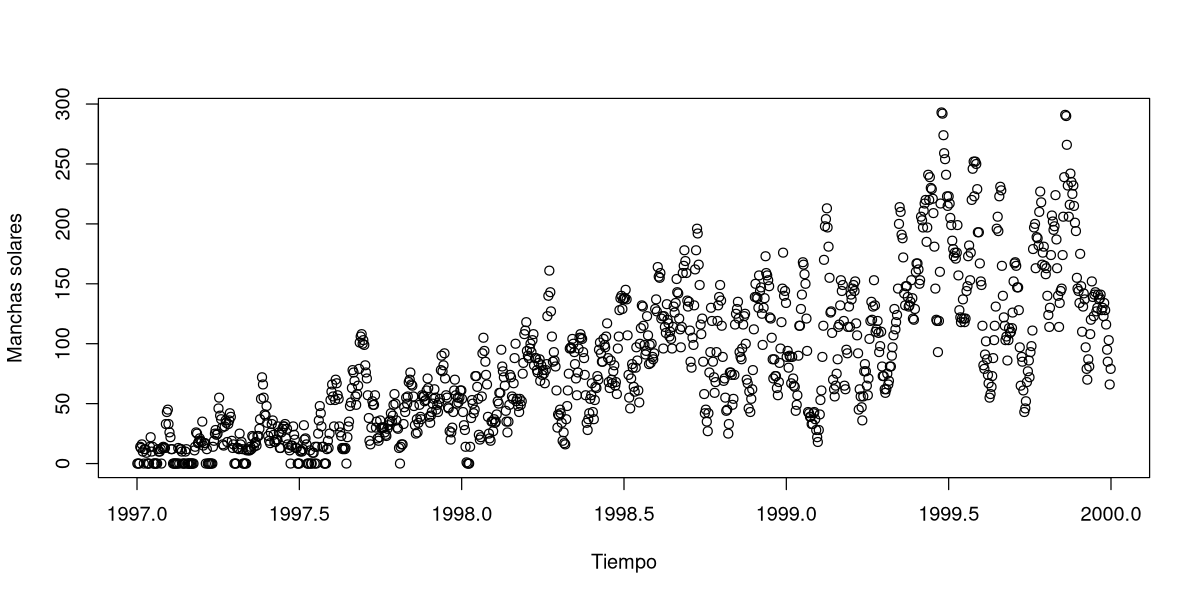

In [6]:
options(repr.plot.width=10, repr.plot.height=5)
plot(x=filtered$decimal.year,y=filtered$SNvalue,xlab="Tiempo",ylab="Manchas solares")

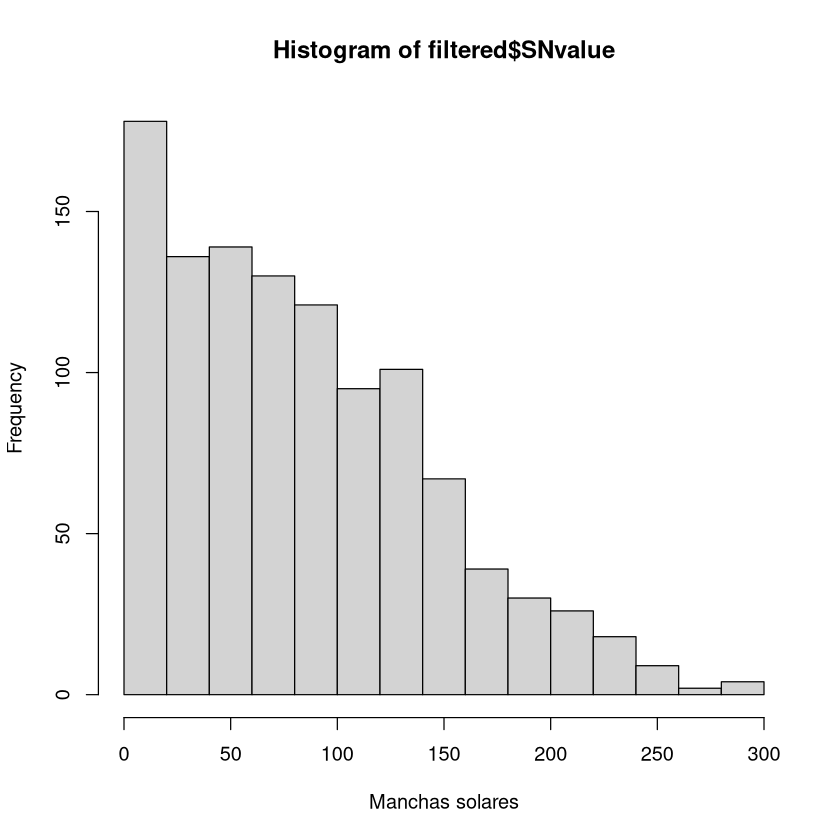

In [7]:
options(repr.plot.width=7, repr.plot.height=7)
hist(filtered$SNvalue,xlab="Manchas solares")

El modelo probabilistico que usaremos sera un $ARMA(1,1)$, es decir

$$X_t=\mu +\varepsilon_t+\varphi X_{t-1}+\theta \varepsilon_{t-1} $$

donde $\varepsilon_t \sim Normal(0,\sigma^2)$ <br>
Se decidio utilizar el mode $ARMA(1,1)$ por su simplicidad para ser implementado, y dado que los datos tienen una clara tendencia de crecimiento lineal <br>
La implementacion de este modelo en STAN lo podemos encontrar en el archivo ***proyecto.stan***

In [21]:
NsunSpots <- filtered$SNvalue
Example <- list(T=nrow(filtered),y=NsunSpots)
modelSpots <- stan("proyecto.stan",data=Example,iter=4000,control=list(adapt_delta = 0.99,max_treedepth = 16))

In [22]:
print(modelSpots)

Inference for Stan model: proyecto.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean   sd     2.5%      25%      50%      75%    97.5% n_eff
mu        2.39    0.01 0.68     1.06     1.92     2.39     2.86     3.72  4285
phi       0.96    0.00 0.01     0.95     0.96     0.96     0.97     0.98  4380
theta     0.25    0.00 0.03     0.20     0.24     0.25     0.27     0.30  5798
sigma    14.24    0.00 0.26    13.73    14.06    14.24    14.42    14.76  5196
lp__  -3659.21    0.02 1.42 -3662.77 -3659.91 -3658.89 -3658.17 -3657.45  3454
      Rhat
mu       1
phi      1
theta    1
sigma    1
lp__     1

Samples were drawn using NUTS(diag_e) at Mon Feb  8 22:38:54 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Con STAN obtuvimos que 

$$\mu \approx 2.39, \; \varphi \approx 0.96, \; \theta \approx 0.25, \; \sigma \approx 14.24 $$

Veamos un primer resultado de esto

In [23]:
ARMA <- function(mu,phi,theta,sigma,X,t){
    errors <- c(rnorm(1,0,sigma))
    y <- c(mu+errors[1]+phi*X[1])
    for(i in 2:t){
        errors[i]=rnorm(1,0,sigma)
        if(i <= length(X)){
            y[i]=mu+errors[i]+phi*X[i-1]+theta*errors[i-1]
        }
        else{
            y[i]=mu+errors[i]+phi*y[i-1]+theta*errors[i-1]
        }
    }
    return(y)
}

In [24]:
modelData <- rstan::extract(modelSpots)

In [25]:
modelSimulated <- ARMA(mean(modelData$mu),mean(modelData$phi),mean(modelData$theta),mean(modelData$sigma),NsunSpots,length(NsunSpots))

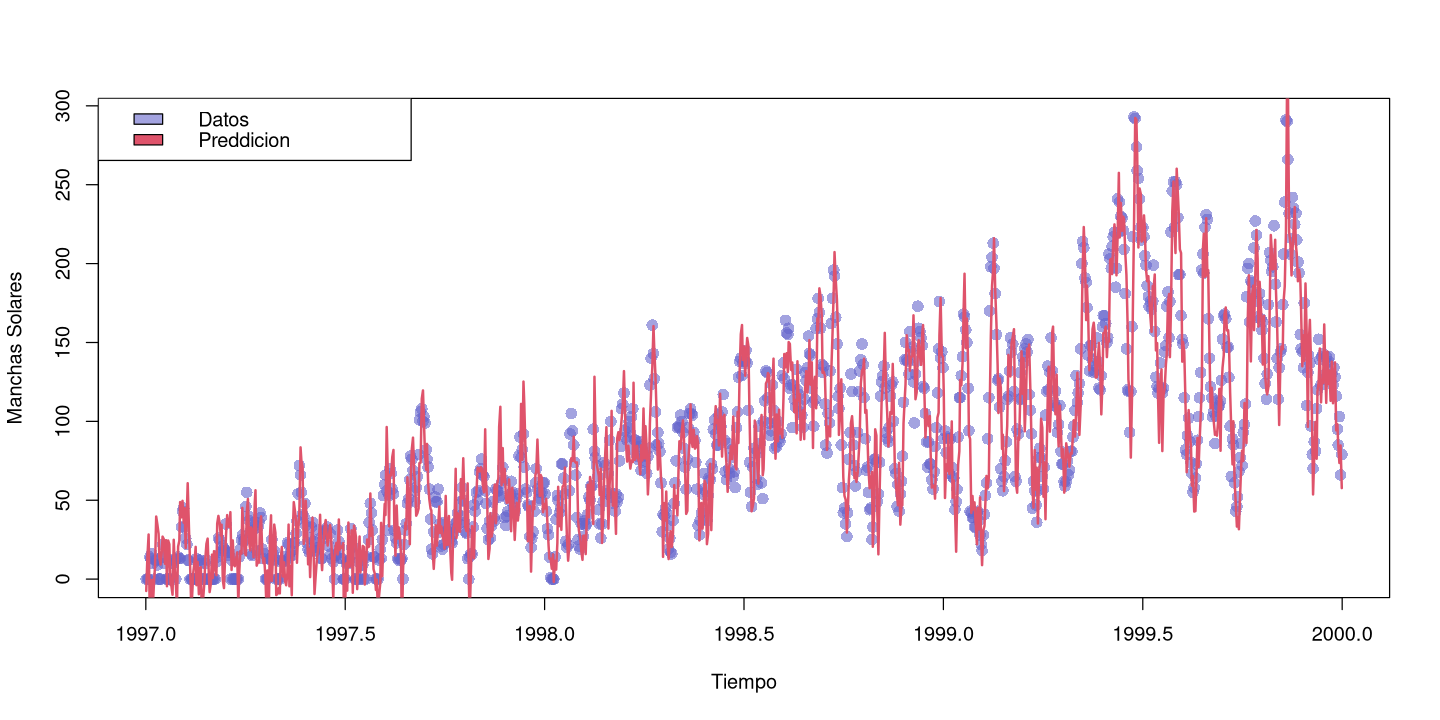

In [26]:
options(repr.plot.width=12, repr.plot.height=6)
plot(x=filtered$decimal.year,y=NsunSpots,col=rgb(0.4,0.4,0.8,0.6),pch=16,cex=1.3,xlab="Tiempo",ylab="Manchas Solares")
lines(x=filtered$decimal.year,y=modelSimulated,col="2",lwd=2)
legend("topleft",c("Datos","Preddicion"),fill=c(rgb(0.4,0.4,0.8,0.6),"2"))

En primera instancia, parece comportarse bien <br>
Ahora, intentemos predecir la cantidad de Manchas solares pasado el 2000 y comparemos con los datos verdaderos

In [39]:
modelPreddiction <- ARMA(mean(modelData$mu),mean(modelData$phi),mean(modelData$theta),mean(modelData$sigma),NsunSpots,length(NsunSpots)+366)

In [40]:
filtered2 <- filtered %>% filter(decimal.year >=1999.5 & decimal.year <= 2000)

In [41]:
real <- datos %>% filter(decimal.year >=2000 & decimal.year <= 2001)

In [42]:
all <- datos %>% filter(decimal.year >=1997 & decimal.year <= 2001)

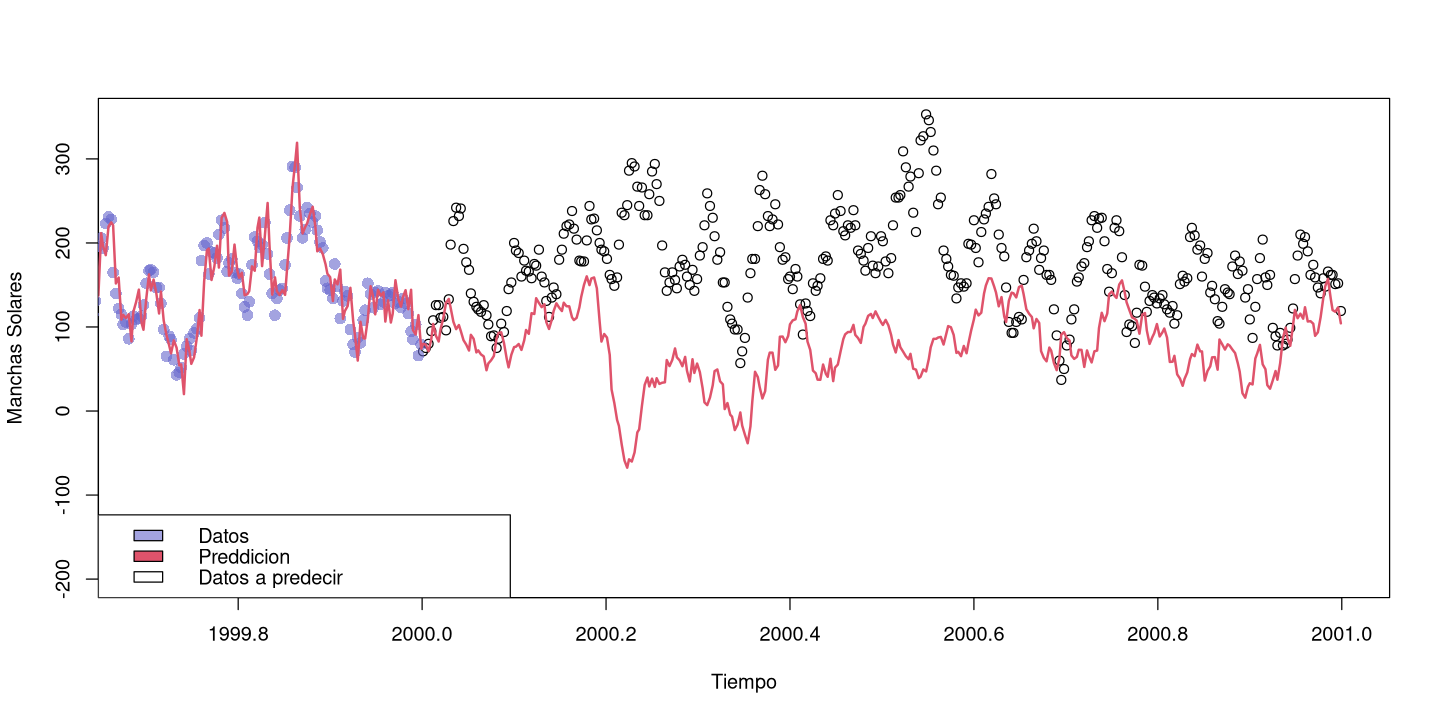

In [43]:
plot(x=real$decimal.year,y=real$SNvalue,xlim=range(1999.7,2001),ylim=range(-200:350),xlab="Tiempo",ylab="Manchas Solares")
points(x=filtered2$decimal.year,y=filtered2$SNvalue,col=rgb(0.4,0.4,0.8,0.6),pch=16,cex=1.3)
lines(x=all$decimal.year,y=modelPreddiction,col="2",lwd=2)
legend("bottomleft",c("Datos","Preddicion","Datos a predecir"),fill=c(rgb(0.4,0.4,0.8,0.6),"2","white"))

Como observamor una preddicion a largo plazo es muy malo. En general se espera que sea asi <br>
Observemos una a corto plazo

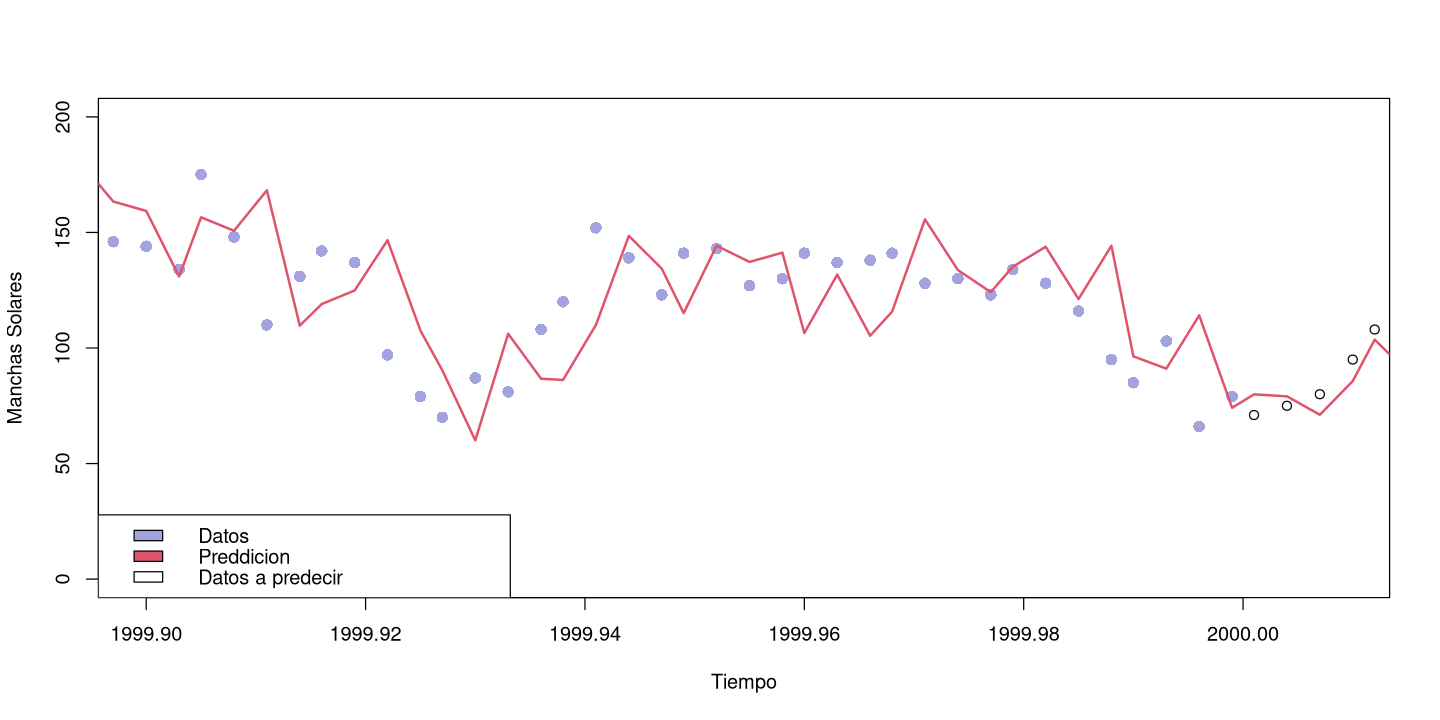

In [44]:
plot(x=real$decimal.year,y=real$SNvalue,xlim=range(1999.9,2000.009),ylim=range(0:200),xlab="Tiempo",ylab="Manchas Solares")
points(x=filtered$decimal.year,y=filtered$SNvalue,col=rgb(0.4,0.4,0.8,0.6),pch=16,cex=1.3)
lines(x=all$decimal.year,y=modelPreddiction,col="2",lwd=2)
legend("bottomleft",c("Datos","Preddicion","Datos a predecir"),fill=c(rgb(0.4,0.4,0.8,0.6),"2","white"))

En este caso, esta prediccion es mucho mas acertada que aquella de largo plazo.

### **Conclusion**

Como se puede observar de las primeras graficas, la estimacion de parametros dados por STAN son fiables: la preddicion sigue muy acorde los datos verdaderos. <br>
Lo que falla en este caso es el modelo usado; el modelo $ARMA(1,1)$ es muy basico, y como se observa para estimaciones grandes falla colosalmente. <br>
Esto puede ser mejorado de muchas maneras: usando un modelo mas general $ARMA(p,q), \; SARIMA(p,1,q)*(P,I,Q)$ o usando en STAN en conjunto con redes neuronales. <br>
Aun asi el modelo es lo suficientemente "bueno" para estimar la tendencia en periodos cortos de tiempo (Esto lo podemos observar en la ultima grafica) lo que nos muestra la fiabilidad de STAN.